# LOADING DATA

## Import Libraries

In [28]:

import os
import glob
import json
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,f1_score,accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer
import ast
from sklearn.preprocessing import OneHotEncoder

# Import necessary libraries
import lightgbm as lgb
import catboost as cb
import xgboost as xgb

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score  # or another appropriate metric

## Loading the data

In [ ]:
train = pd.read_csv("data/train.csv")
val = pd.read_csv("data/val.csv")
test = pd.read_csv("data/new_test.csv")

# EDA

In [5]:
train.head()

,id,age,tenure,service_type,avg_call_duration,data_usage,roaming_usage,monthly_charge,overdue_payments,auto_payment,avg_top_up_count,call_drops,customer_support_calls,satisfaction_score,apps,churn
0,a34b17e3-792a-4ad9-9355-de5eb66db24a,35,236.0,Broadband,NaN,54.15,NaN,449.12,5,1.0,0,NaN,16,1.05,[],False
1,1a21c386-4b81-4b3b-981c-caaca3174d1a,18,290.0,Prepaid,NaN,103.61,21.48,1719.49,0,NaN,99,14.0,0,9.18,['Konuşalım'],False
2,5ff4f637-9eac-4fb7-aa6d-11d53bac2025,22,143.0,Broadband,NaN,NaN,NaN,345.51,0,1.0,0,NaN,13,7.08,['İzleGo'],False
3,ab8ec263-8323-45ca-bb7b-a4cb408db34d,25,214.0,Postpaid,67.60,169.18,21.15,659.27,2,1.0,0,13.0,8,6.88,[],False
4,e2f22d33-1c07-4805-b682-5ee24d8b858e,18,243.0,Prepaid,39.85,150.25,44.82,813.68,0,NaN,81,4.0,19,9.90,['RitimGo'],False


In [6]:
train.isnull().sum()

id                              0
age                             0
tenure                      19801
service_type                    0
avg_call_duration         2932038
data_usage                 399226
roaming_usage             2665686
monthly_charge             200211
overdue_payments                0
auto_payment              2676284
avg_top_up_count                0
call_drops                2665686
customer_support_calls          0
satisfaction_score              0
apps                            0
churn                           0
dtype: int64

In [212]:
histogram_columns = ["tenure","avg_call_duration","data_usage","roaming_usage","monthly_charge","satisfaction_score"]

discrete_columns = ["overdue_payments","auto_payment","call_drops","customer_support_calls"]

other_columns = ["avg_top_up_count","apps"]


In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot histogram for non-churn customers
plt.hist(train[train['churn'] == 0]['avg_top_up_count'], bins=10, alpha=0.5, 
         label='No Churn', density=True, edgecolor='black')

# Plot histogram for churn customers
plt.hist(train[train['churn'] == 1]['avg_top_up_count'], bins=10, alpha=0.5, 
         label='Churn', density=True, edgecolor='black', color='orange')

plt.title('Normalized Distribution of Tenture by Churn Status')
plt.xlabel('Tenture')
plt.ylabel('Density')
plt.legend()
plt.show()


NameError: name 'train' is not defined

<Figure size 1000x600 with 0 Axes>

# Preprocessing

### modules

In [14]:
def filling_null_values(df):
        
    # Service Type:
    mask = (df['service_type'] == 'Prepaid') & (df['auto_payment'].isna())

    # Fill null auto_payment values with 0 for those rows
    df.loc[mask, 'auto_payment'] = 0

    # Create a mask for rows where customer_support_calls == 0 and avg_call_duration is null
    mask = (df['customer_support_calls'] == 0) & (df['avg_call_duration'].isna())

    # Update avg_call_duration to 0 for those rows
    df.loc[mask, 'avg_call_duration'] = 0

    return df 
    

def feature_extraction(dff):
    df = dff.copy()

    eps = 1e-5  # Sıfır bölünmesini önlemek için

    df['total_call_duration'] = df['avg_call_duration'] * df['customer_support_calls']
    df['overdue_payment_ratio'] = df['overdue_payments'] / (df['tenure'] + eps)
    df['lifetime_value'] = df['monthly_charge'] * df['tenure']
    df['age_tenure_ratio'] = df['tenure'] / (df['age'] + eps)
    df['satisfaction_support'] = df['satisfaction_score'] / (df['customer_support_calls'] + eps)
    df['call_drop_ratio'] = np.where(
    df['customer_support_calls'] != 0,
    df['call_drops'] / df['customer_support_calls'],
    0  # or np.nan if you prefer to mark division-by-zero cases as missing
    )

    # 9. Müşteri Etkileşim Skoru (Customer Engagement Score)
    # İlk olarak, kullanılan uygulama sayısını hesaplayalım.
    app_columns = ['İzleGo', 'RitimGo', 'CüzdanX', 'HızlıPazar', 'Konuşalım']
    df['total_apps_used'] = df[app_columns].sum(axis=1)


    return df




In [15]:
def preprocess(df,train = True,mlb = None,encoder = None):

    df = df.drop(columns=["id"],axis = 1)

    df = filling_null_values(df)

    df['apps'] = df['apps'].apply(ast.literal_eval)

    if train:
        # MultiLabelBinarizer for apps
        mlb = MultiLabelBinarizer()
        one_hot_apps = mlb.fit_transform(df['apps'])
        df_onehot = pd.DataFrame(one_hot_apps, columns=mlb.classes_, index=df.index)
        df_encoded = df.join(df_onehot)

        # Service type encoding
        encoder = OneHotEncoder(sparse_output = False)
        one_hot_encoded = encoder.fit_transform(df_encoded[['service_type']])
        # The column names are available in encoder.categories_[0]
        df_one_hot_new = pd.DataFrame(one_hot_encoded, columns=encoder.categories_[0], index=df_encoded.index)
        df_encoded_new = pd.concat([df_encoded, df_one_hot_new], axis=1)

    else:
        one_hot = mlb.transform(df['apps'])
        df_onehot = pd.DataFrame(one_hot, columns=mlb.classes_, index=df.index)
        df_encoded = df.join(df_onehot)

        one_hot_encoded = encoder.transform(df_encoded[['service_type']])
        df_one_hot_new = pd.DataFrame(one_hot_encoded, columns=encoder.categories_[0], index=df_encoded.index)
        df_encoded_new = pd.concat([df_encoded, df_one_hot_new], axis=1)

    df_encoded_new = df_encoded_new.drop(columns=["service_type","apps"],axis = 1)

    df_final = feature_extraction(df_encoded_new)
    return df_final,mlb,encoder

from sklearn.utils import resample
import pandas as pd


def undersample_data(X, y, majority_multiplier=3, random_state=42):
    """
    Undersample the dataset so that the majority class has a specified multiple of 
    the number of samples in the minority class.

    Parameters:
        X (pd.DataFrame): The feature DataFrame.
        y (pd.Series): The target Series.
        majority_multiplier (int): The factor by which the majority class should 
                                   exceed the minority class count after undersampling.
        random_state (int): Seed for reproducibility.
    
    Returns:
        X_res (pd.DataFrame): The undersampled features DataFrame.
        y_res (pd.Series): The undersampled target Series.
    """
    # Combine X and y into a single DataFrame for easier manipulation.
    train_data = X.copy()
    train_data['target'] = y

    # Display original class counts
    print("Before undersampling:")
    print(train_data['target'].value_counts())

    # Determine the counts for each class.
    target_counts = train_data['target'].value_counts()
    # Identify the minority class and its count.
    minority_class = target_counts.idxmin()
    minority_count = target_counts.min()

    # Define the desired sample sizes for each class.
    desired_counts = {}
    for cls, count in target_counts.items():
        if cls == minority_class:
            desired_counts[cls] = minority_count  # Keep all minority samples.
        else:
            desired_counts[cls] = majority_multiplier * minority_count  # Undersample majority.
    
    # Resample each class accordingly using sklearn's resample.
    resampled_list = []
    for cls in train_data['target'].unique():
        cls_data = train_data[train_data['target'] == cls]
        # Ensure we don't attempt to sample more than available.
        n_samples = min(desired_counts[cls], len(cls_data))
        cls_data_downsampled = resample(
            cls_data,
            replace=False,
            n_samples=n_samples,
            random_state=random_state
        )
        resampled_list.append(cls_data_downsampled)

    # Concatenate the resampled data for all classes.
    undersampled_data = pd.concat(resampled_list)

    # Shuffle the undersampled dataset to mix class samples.
    undersampled_data = undersampled_data.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Split back into X and y.
    X_res = undersampled_data.drop(columns=['target'])
    y_res = undersampled_data['target']

    print("\nAfter undersampling:")
    print(y_res.value_counts())

    return X_res, y_res



In [16]:
def print_all_metrics(preds,preds_proba,true):
    
    acc = accuracy_score(true, preds)
    cm = confusion_matrix(true, preds)
    precision = precision_score(true, preds)
    recall = recall_score(true, preds)
    f1 = f1_score(true, preds)  
    auc = roc_auc_score(true, preds_proba)

    print("Accuracy:",acc)
    print("Precision:", precision)  
    print("Recall:", recall)        
    print("F1 Score:", f1)
    print("auc:", auc)
    print("cm:", cm)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()




### splitting the data

In [ ]:
X_train = train.drop(columns=["churn"],axis = 1)
y_train = train["churn"]

X_val = val.drop(columns=["churn"],axis = 1)
y_val = val["churn"]

X_test = test.drop(columns=["churn"],axis = 1)
y_test = test["churn"]

### implement preprocessing

In [18]:
df_train,mlb,encoder = preprocess(X_train)
df_val,_,_ = preprocess(X_val,train = False,mlb = mlb,encoder = encoder)
df_test,_,_ = preprocess(X_test,train = False,mlb = mlb,encoder = encoder)

In [22]:
df_x_train, df_y_train = undersample_data(df_train, y_train, majority_multiplier=5)

Before undersampling:
target
False    7893078
True      106922
Name: count, dtype: int64

After undersampling:
target
False    534610
True     106922
Name: count, dtype: int64


# Model evaluation

In [19]:
# DATA:
# df_x_train-df_y_train
# df_val-y_val
# df_test-y_test

## train

### lgb

In [23]:
lgb_params = { "objective": "binary",
                  "boosting_type": "gbdt",
                    'n_estimators': 309,
                      'learning_rate': 0.01716029728096218,
                        'num_leaves': 22,
                          'max_depth': 6, 
                          'min_child_samples': 10, 
                          'subsample': 0.737440646376928,
                            'colsample_bytree': 0.9862597807809604,
                              'reg_alpha': 8.985515005642144e-07, 
                              'reg_lambda': 1.00016444438518084528, 
                    "random_state": 42,   
                    "verbose":100,
                    "n_jobs": -1  }

lgb_classifier = lgb.LGBMClassifier(**lgb_params)
lgb_classifier.fit(df_x_train, df_y_train)


[LightGBM] [Info] Number of positive: 106922, number of negative: 534610
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.867546
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.285285
[LightGBM] [Debug] init for col-wise cost 0.011246 seconds, init for row-wise cost 0.030277 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 3284
[LightGBM] [Info] Number of data points in the train set: 641532, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 6
[Light

LGBMClassifier(colsample_bytree=0.9862597807809604,
               learning_rate=0.01716029728096218, max_depth=6,
               min_child_samples=10, n_estimators=309, n_jobs=-1, num_leaves=22,
               objective='binary', random_state=42,
               reg_alpha=8.985515005642144e-07, reg_lambda=1.000164444385181,
               subsample=0.737440646376928, verbose=100)

### xgb

In [114]:

# XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 1000,
    'learning_rate': 0.014535055516021658,
    'max_depth': 6,
    'subsample': 0.8358313411573967,
    'colsample_bytree': 0.7388264773326583,
    'random_state': 42,
    "verbose": -1,
    'n_jobs': -1
}

xgb_classifier = xgb.XGBClassifier(**xgb_params)

xgb_classifier.fit(train, y_train_res,eval_set=[(val, y_val)])

[0]	validation_0-auc:0.70287
[1]	validation_0-auc:0.71218
[2]	validation_0-auc:0.76078
[3]	validation_0-auc:0.75470
[4]	validation_0-auc:0.77958
[5]	validation_0-auc:0.78572
[6]	validation_0-auc:0.78542
[7]	validation_0-auc:0.78418
[8]	validation_0-auc:0.78499
[9]	validation_0-auc:0.78594
[10]	validation_0-auc:0.78539
[11]	validation_0-auc:0.78605
[12]	validation_0-auc:0.78561
[13]	validation_0-auc:0.78580
[14]	validation_0-auc:0.78566
[15]	validation_0-auc:0.78616
[16]	validation_0-auc:0.78682
[17]	validation_0-auc:0.78637
[18]	validation_0-auc:0.78688
[19]	validation_0-auc:0.78641
[20]	validation_0-auc:0.78650
[21]	validation_0-auc:0.78693
[22]	validation_0-auc:0.78708
[23]	validation_0-auc:0.78702
[24]	validation_0-auc:0.78690
[25]	validation_0-auc:0.78675
[26]	validation_0-auc:0.78661
[27]	validation_0-auc:0.78654
[28]	validation_0-auc:0.78664
[29]	validation_0-auc:0.78666
[30]	validation_0-auc:0.78626
[31]	validation_0-auc:0.78606
[32]	validation_0-auc:0.78614
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7388264773326583, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.014535055516021658,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

### catboost

In [ ]:
# CatBoost parameters
cat_params = {
    'iterations': 1000,
    'learning_rate': 0.014535055516021658,
    'depth': 8,
    'loss_function': 'Logloss',      # Logloss for binary classification
    'eval_metric': 'AUC',
    'random_seed': 42,
    # If you have categorical features, you can pass their indices via cat_features parameter during fit.
}

cat_classifier = cb.CatBoostClassifier(**cat_params)

cat_classifier.fit(train, y_train_res,eval_set=[(val, y_val)])


0:	test: 0.7885291	best: 0.7885291 (0)	total: 68.8ms	remaining: 1m 8s
1:	test: 0.7904225	best: 0.7904225 (1)	total: 129ms	remaining: 1m 4s
2:	test: 0.7904086	best: 0.7904225 (1)	total: 185ms	remaining: 1m 1s
3:	test: 0.7918166	best: 0.7918166 (3)	total: 246ms	remaining: 1m 1s
4:	test: 0.7921409	best: 0.7921409 (4)	total: 307ms	remaining: 1m 1s
5:	test: 0.7924646	best: 0.7924646 (5)	total: 369ms	remaining: 1m 1s
6:	test: 0.7929502	best: 0.7929502 (6)	total: 425ms	remaining: 1m
7:	test: 0.7928834	best: 0.7929502 (6)	total: 482ms	remaining: 59.8s
8:	test: 0.7928094	best: 0.7929502 (6)	total: 543ms	remaining: 59.7s
9:	test: 0.7929976	best: 0.7929976 (9)	total: 610ms	remaining: 1m
10:	test: 0.7929214	best: 0.7929976 (9)	total: 749ms	remaining: 1m 7s
11:	test: 0.7932006	best: 0.7932006 (11)	total: 823ms	remaining: 1m 7s
12:	test: 0.7932966	best: 0.7932966 (12)	total: 888ms	remaining: 1m 7s
13:	test: 0.7932302	best: 0.7932966 (12)	total: 957ms	remaining: 1m 7s
14:	test: 0.7933509	best: 0.7933

## evaluation

### ensemble 

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create the voting classifier with soft voting (averaging probabilities)
ensemble_classifier = VotingClassifier(
    estimators=[('lgb', lgb_classifier),('xgb', xgb_classifier),('cat', cat_classifier)],
    voting='soft',  # Use soft voting to average predicted probabilities
    n_jobs=-1
)

# Fit the ensemble (if needed; if your base classifiers are already trained and you want to use them as-is, 
# you might simply use their predictions)
ensemble_classifier.fit(train, y_train_res)

0:	total: 74.4ms	remaining: 1m 14s
1:	total: 89.9ms	remaining: 44.9s
2:	total: 104ms	remaining: 34.6s
3:	total: 120ms	remaining: 30s
4:	total: 134ms	remaining: 26.6s
5:	total: 149ms	remaining: 24.6s
[LightGBM] [Warning] Unknown parameter: stopping_rounds
[LightGBM] [Warning] Unknown parameter: eval_metric
6:	total: 164ms	remaining: 23.2s
7:	total: 180ms	remaining: 22.3s
8:	total: 207ms	remaining: 22.8s
9:	total: 225ms	remaining: 22.3s
10:	total: 253ms	remaining: 22.8s
[LightGBM] [Warning] Unknown parameter: stopping_rounds
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 106922, number of negative: 106922
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.945299
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.307168
[LightGBM] [Debug] init for col-wise cost 0.004612 seconds, init for row-wise cost 0.012381 seconds
11:	total: 279ms	remaining: 23s
[LightGBM] [Info] Auto-choosing row-wise multi-threading,

[LightGBM] [Warning] Unknown parameter: stopping_rounds
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: stopping_rounds
[LightGBM] [Warning] Unknown parameter: eval_metric
Precision: 0.03217541034667168
Recall: 0.819304152637486
auc: 0.8009513974319151


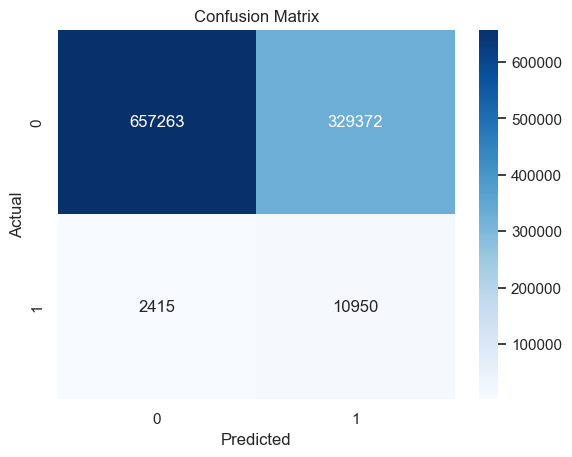

In [139]:
# Predict on new data (for example, on validation or test set)
ensemble_preds = ensemble_classifier.predict(test)
ensemble_preds_proba = ensemble_classifier.predict_proba(test)[:, 1]


cm = confusion_matrix(y_test, ensemble_preds)
# Assuming y_test and y_pred are defined as in your code
precision = precision_score(y_test, ensemble_preds)
recall = recall_score(y_test, ensemble_preds)
auc = roc_auc_score(y_test, ensemble_preds_proba)

print("Precision:", precision) # GİDECEK DEDİKLERİMİN KAÇ TANESİ GİDECEK
print("Recall:", recall) # GİDECEK OLANLARIN KAÇ TANESİNİ BİLDİM
print("auc:", auc)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### lgb evaluation

Accuracy: 0.975141
Precision: 0.09014405933533019
Recall: 0.09457538346427236
F1 Score: 0.09230656881001935
auc: 0.8002892345687581
cm: [[973877  12758]
 [ 12101   1264]]


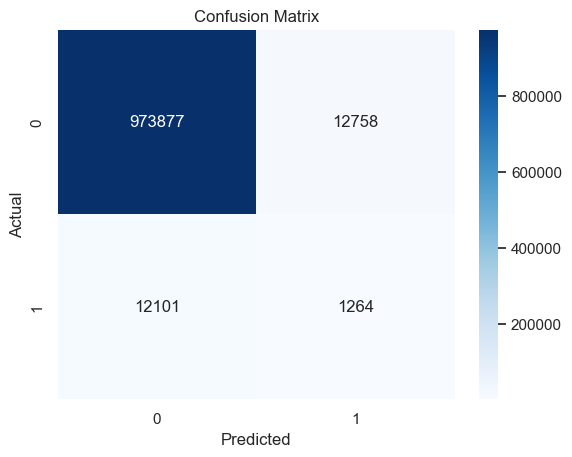

In [ ]:
y_pred = lgb_classifier.predict(df_test)
y_pred_proba = lgb_classifier.predict_proba(df_test)[:, 1]

cm = print_all_metrics(y_pred,y_pred_proba,y_test)


## Cross Validation

In [27]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate


# Define your LightGBM parameters
lgb_params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    'n_estimators': 309,
    'learning_rate': 0.01716029728096218,
    'num_leaves': 22,
    'max_depth': 6, 
    'min_child_samples': 10, 
    'subsample': 0.737440646376928,
    'colsample_bytree': 0.9862597807809604,
    'reg_alpha': 8.985515005642144e-07, 
    'reg_lambda': 1.00016444438518084528, 
    "random_state": 42,   
    "verbose": 100,
    "n_jobs": -1  
}

# Create the classifier
lgb_classifier = lgb.LGBMClassifier(**lgb_params)

# Set up StratifiedKFold (good for classification tasks)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the metrics you want to evaluate
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(lgb_classifier, df_x_train, df_y_train, cv=cv, scoring=scoring)

# Print out the mean of each metric across the folds
for metric in scoring:
    score_mean = cv_results['test_' + metric].mean()
    print(f"Mean {metric}: {score_mean:.4f}")

[LightGBM] [Info] Number of positive: 85537, number of negative: 427688
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.867189
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.285193
[LightGBM] [Debug] init for col-wise cost 0.006446 seconds, init for row-wise cost 0.026983 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 3281
[LightGBM] [Info] Number of data points in the train set: 513225, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609445
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 6
[LightG

In [26]:
print(cv_results)

{'fit_time': array([5.1164999 , 4.76238608, 5.227566  , 4.21362686, 4.47711611]), 'score_time': array([0.7761941 , 0.86961007, 0.79713416, 0.78668118, 0.81384206]), 'test_accuracy': array([0.83781867, 0.83837982, 0.83800446, 0.83816813, 0.83756021]), 'test_precision': array([0.58674699, 0.5958013 , 0.59007519, 0.5921522 , 0.58123501]), 'test_recall': array([0.09109189, 0.09422492, 0.09175084, 0.09315376, 0.09067527]), 'test_f1': array([0.15770087, 0.16271652, 0.15880853, 0.16098271, 0.15687702]), 'test_roc_auc': array([0.79914539, 0.79956607, 0.80003419, 0.79701673, 0.79842216])}


# PostProcessing

## optuna lgb

[I 2025-02-07 17:04:35,526] A new study created in memory with name: no-name-4bc367dc-bd58-411a-aa0a-e3995ea688a3


Accuracy: 0.975281
Precision: 0.09035144692213322
Recall: 0.09367050725721981
F1 Score: 0.09198104543951806
auc: 0.7984545549233166
cm: [[974029  12605]
 [ 12114   1252]]


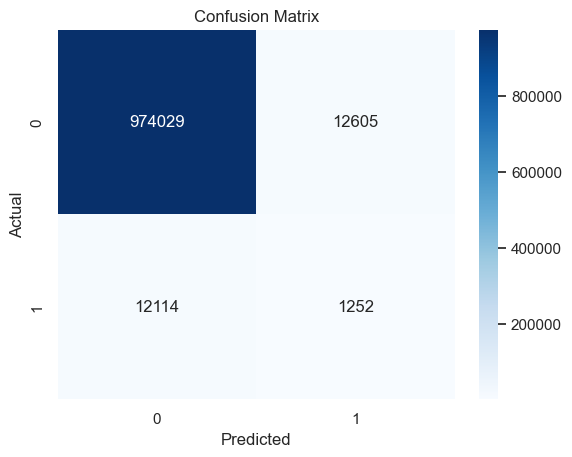

[I 2025-02-07 17:05:08,110] Trial 0 finished with value: 0.09198104543951806 and parameters: {'n_estimators': 1069, 'learning_rate': 0.020199094325224994, 'num_leaves': 20, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.7083062292786696, 'colsample_bytree': 0.7275575506804631, 'reg_alpha': 3.298815602974688e-05, 'reg_lambda': 6.457907512834074e-06}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.974844
Precision: 0.08862526168876483
Recall: 0.09501720784079007
F1 Score: 0.09170999422299249
auc: 0.7976359596055325
cm: [[973574  13060]
 [ 12096   1270]]


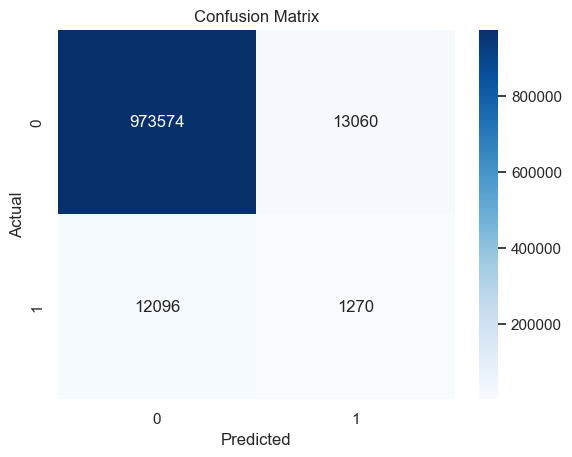

[I 2025-02-07 17:05:45,874] Trial 1 finished with value: 0.09170999422299249 and parameters: {'n_estimators': 1430, 'learning_rate': 0.07184951403537886, 'num_leaves': 23, 'max_depth': 3, 'min_child_samples': 44, 'subsample': 0.9018205156751866, 'colsample_bytree': 0.8792609633857374, 'reg_alpha': 0.008114249086148741, 'reg_lambda': 5.347215310653969e-05}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.975339
Precision: 0.09049380030454644
Recall: 0.09337124046087086
F1 Score: 0.09191000478697942
auc: 0.79816950561565
cm: [[974091  12543]
 [ 12118   1248]]


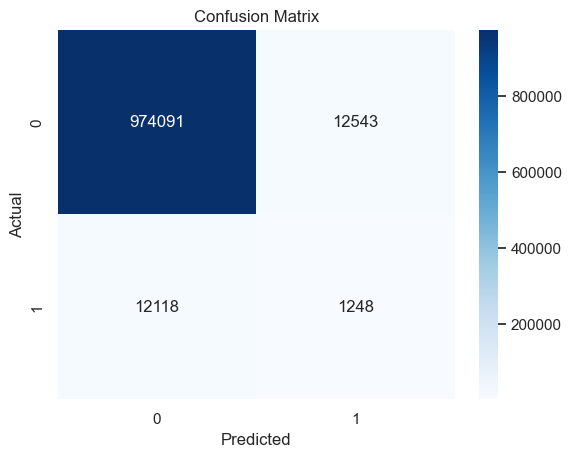

[I 2025-02-07 17:05:58,792] Trial 2 finished with value: 0.09191000478697942 and parameters: {'n_estimators': 228, 'learning_rate': 0.01674531556795686, 'num_leaves': 40, 'max_depth': 8, 'min_child_samples': 39, 'subsample': 0.8547735182575409, 'colsample_bytree': 0.75198858677037, 'reg_alpha': 1.5148377334495313, 'reg_lambda': 1.409754737001261e-07}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.975202
Precision: 0.08995695839311334
Recall: 0.09382014065539429
F1 Score: 0.09184794550648209
auc: 0.7982508549766983
cm: [[973948  12686]
 [ 12112   1254]]


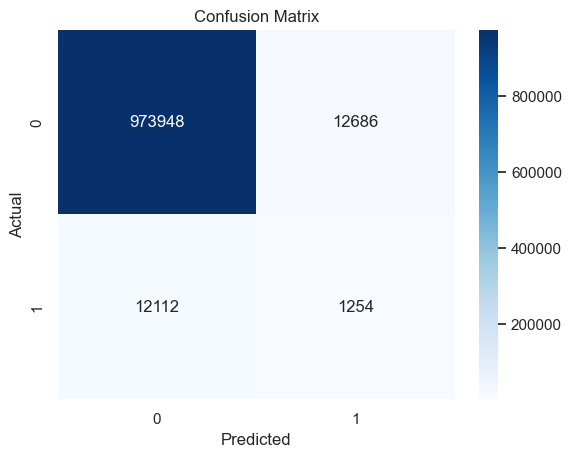

[I 2025-02-07 17:06:23,591] Trial 3 finished with value: 0.09184794550648209 and parameters: {'n_estimators': 649, 'learning_rate': 0.03187759927179959, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.9837552033010617, 'colsample_bytree': 0.8062453127926033, 'reg_alpha': 0.06894138744118344, 'reg_lambda': 1.1168821354361574e-08}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.975246
Precision: 0.09006479481641469
Recall: 0.09359569055813258
F1 Score: 0.0917963017317288
auc: 0.7979088247367372
cm: [[973995  12639]
 [ 12115   1251]]


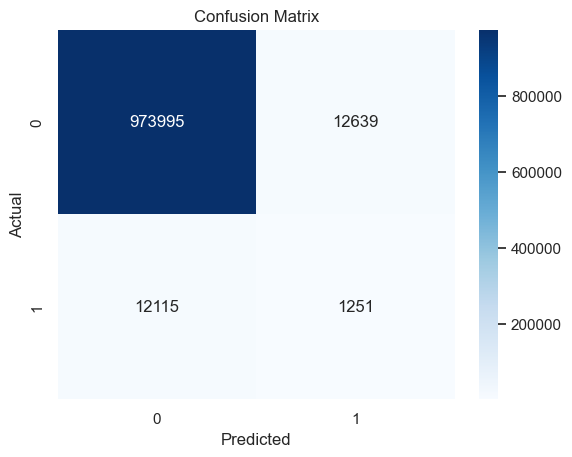

[I 2025-02-07 17:07:08,261] Trial 4 finished with value: 0.0917963017317288 and parameters: {'n_estimators': 957, 'learning_rate': 0.02240321947536288, 'num_leaves': 43, 'max_depth': 5, 'min_child_samples': 31, 'subsample': 0.7654581291962247, 'colsample_bytree': 0.8168888940597304, 'reg_alpha': 6.764350766994073, 'reg_lambda': 0.0003653232382711377}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.974716
Precision: 0.08681181528220774
Recall: 0.09367050725721981
F1 Score: 0.09011083921117029
auc: 0.7978577902227708
cm: [[973464  13170]
 [ 12114   1252]]


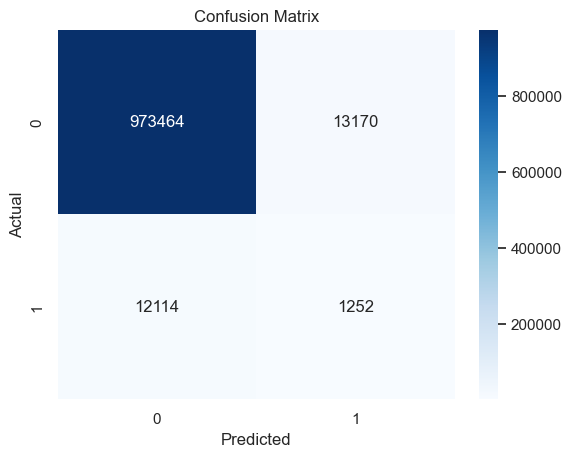

[I 2025-02-07 17:07:44,578] Trial 5 finished with value: 0.09011083921117029 and parameters: {'n_estimators': 1311, 'learning_rate': 0.07788253713108607, 'num_leaves': 28, 'max_depth': 3, 'min_child_samples': 30, 'subsample': 0.7019447683838588, 'colsample_bytree': 0.9908840450931942, 'reg_alpha': 0.0002718546478618769, 'reg_lambda': 1.9394176923373444e-05}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.973534
Precision: 0.08285568717360846
Recall: 0.09733652551249439
F1 Score: 0.08951424246594193
auc: 0.7972722330051163
cm: [[972233  14401]
 [ 12065   1301]]


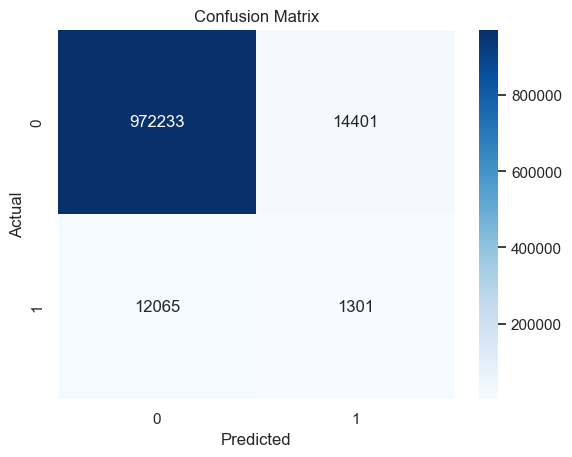

[I 2025-02-07 17:08:42,151] Trial 6 finished with value: 0.08951424246594193 and parameters: {'n_estimators': 1481, 'learning_rate': 0.04593816638370144, 'num_leaves': 29, 'max_depth': 7, 'min_child_samples': 45, 'subsample': 0.7074036667517307, 'colsample_bytree': 0.8517107775249555, 'reg_alpha': 7.129040185111429e-07, 'reg_lambda': 3.2112787376190415}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.975211
Precision: 0.09019157637942168
Recall: 0.09404459075265599
F1 Score: 0.09207779364904956
auc: 0.7981839116941545
cm: [[973954  12680]
 [ 12109   1257]]


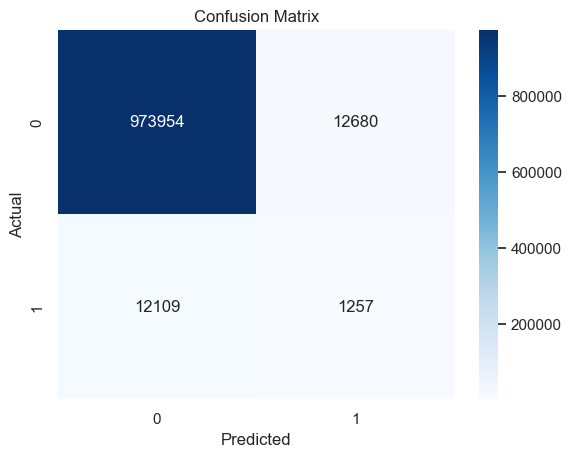

[I 2025-02-07 17:09:41,867] Trial 7 finished with value: 0.09207779364904956 and parameters: {'n_estimators': 1170, 'learning_rate': 0.017307394847376534, 'num_leaves': 32, 'max_depth': 5, 'min_child_samples': 47, 'subsample': 0.8820272962491129, 'colsample_bytree': 0.8793114002570276, 'reg_alpha': 2.3867994735963864e-06, 'reg_lambda': 1.6423043262268617e-07}. Best is trial 7 with value: 0.09207779364904956.


Accuracy: 0.975086
Precision: 0.08973994599971578
Recall: 0.0944934909471794
F1 Score: 0.09205539358600583
auc: 0.798058589434983
cm: [[973823  12811]
 [ 12103   1263]]


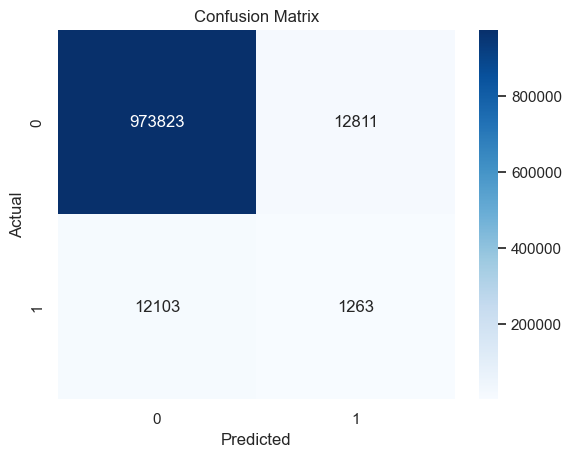

[I 2025-02-07 17:10:09,207] Trial 8 finished with value: 0.09205539358600583 and parameters: {'n_estimators': 819, 'learning_rate': 0.040665239959192793, 'num_leaves': 22, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.92222428649627, 'colsample_bytree': 0.9398235420283401, 'reg_alpha': 0.000144775064349058, 'reg_lambda': 0.7835148603869116}. Best is trial 7 with value: 0.09207779364904956.


Accuracy: 0.975478
Precision: 0.09063554968442683
Recall: 0.0923986233727368
F1 Score: 0.09150859513930053
auc: 0.7981010535386983
cm: [[974243  12391]
 [ 12131   1235]]


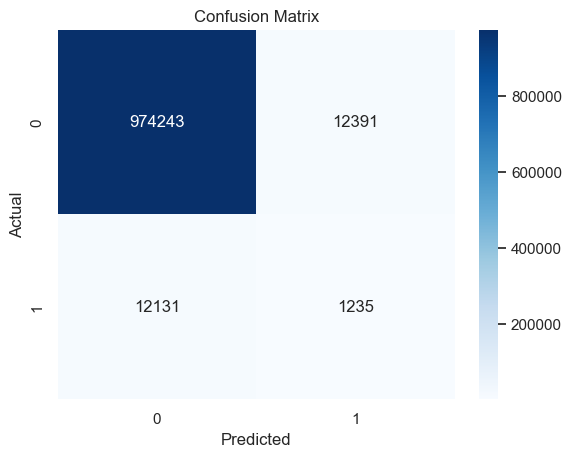

[I 2025-02-07 17:10:24,647] Trial 9 finished with value: 0.09150859513930053 and parameters: {'n_estimators': 311, 'learning_rate': 0.01196148491738121, 'num_leaves': 20, 'max_depth': 7, 'min_child_samples': 40, 'subsample': 0.7536816747055917, 'colsample_bytree': 0.6873117598456991, 'reg_alpha': 0.0005153020454937134, 'reg_lambda': 0.004816726096338321}. Best is trial 7 with value: 0.09207779364904956.


Accuracy: 0.975337
Precision: 0.09048067860508954
Recall: 0.09337124046087086
F1 Score: 0.0919032364961891
auc: 0.7981201668555633
cm: [[974089  12545]
 [ 12118   1248]]


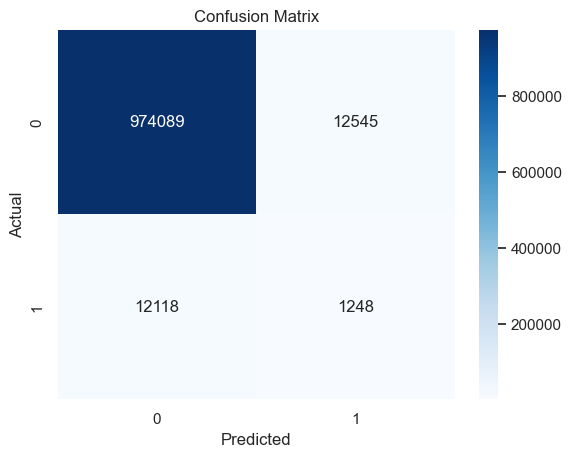

[I 2025-02-07 17:10:54,948] Trial 10 finished with value: 0.0919032364961891 and parameters: {'n_estimators': 575, 'learning_rate': 0.01005813248560256, 'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 50, 'subsample': 0.8316365774286807, 'colsample_bytree': 0.6010924225392429, 'reg_alpha': 1.1887492784402807e-08, 'reg_lambda': 6.190050488481481e-07}. Best is trial 7 with value: 0.09207779364904956.


Accuracy: 0.974601
Precision: 0.08788273169395164
Recall: 0.09598982492892413
F1 Score: 0.09175755408546397
auc: 0.7975111741865886
cm: [[973318  13316]
 [ 12083   1283]]


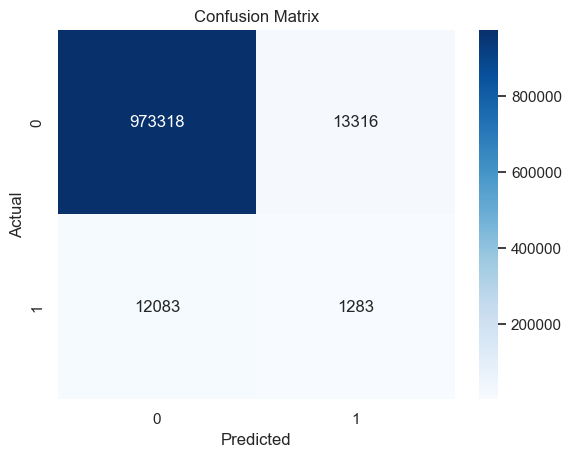

[I 2025-02-07 17:11:43,601] Trial 11 finished with value: 0.09175755408546397 and parameters: {'n_estimators': 1102, 'learning_rate': 0.040377504789323566, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.9448388817145054, 'colsample_bytree': 0.9444740860368843, 'reg_alpha': 2.6356931610813373e-06, 'reg_lambda': 2.0480581922746817}. Best is trial 7 with value: 0.09207779364904956.


Accuracy: 0.974236
Precision: 0.08601576065179645
Recall: 0.09636390842436032
F1 Score: 0.09089625970359916
auc: 0.7977967710644627
cm: [[972948  13686]
 [ 12078   1288]]


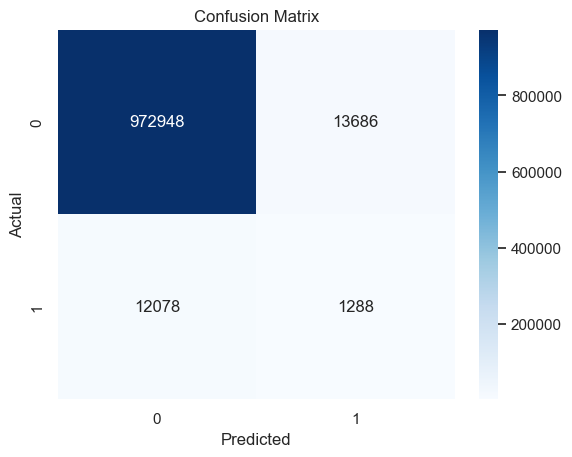

[I 2025-02-07 17:12:16,391] Trial 12 finished with value: 0.09089625970359916 and parameters: {'n_estimators': 821, 'learning_rate': 0.05115405192738944, 'num_leaves': 26, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.6012326853975243, 'colsample_bytree': 0.9255095487200273, 'reg_alpha': 2.1977211933562137e-07, 'reg_lambda': 0.05340171558622164}. Best is trial 7 with value: 0.09207779364904956.
[W 2025-02-07 17:12:32,254] Trial 13 failed with parameters: {'n_estimators': 1183, 'learning_rate': 0.026665252819446567, 'num_leaves': 35, 'max_depth': 8, 'min_child_samples': 34, 'subsample': 0.9012512696452473, 'colsample_bytree': 0.9020318774394555, 'reg_alpha': 1.3114769315673066e-05, 'reg_lambda': 0.10840013782573037} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/cekubalp/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^

KeyboardInterrupt: 

In [36]:
import optuna
import lightgbm as lgb

# DATA:
# df_x_train-df_y_train
# df_val-y_val
# df_test-y_test

def objective(trial):
    # Define a search space for each hyperparameter you want to tune
    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "subsample_freq": 1,  # Fixed value; adjust if needed
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "verbose": -1,
        "n_jobs": -1
    }

    # Create the LightGBM classifier with the trial's parameters
    lgb_classifier = lgb.LGBMClassifier(**params)
    
    # Train the model on training data and evaluate on the validation set
    lgb_classifier.fit(
        df_x_train, df_y_train,
    )
    
    # Get predicted probabilities for the positive class
    pred_probs = lgb_classifier.predict_proba(df_val)[:, 1]
    preds = lgb_classifier.predict(df_val)
    print_all_metrics(preds = preds,true = y_val,preds_proba = pred_probs)
    
    f1 = f1_score(y_val, preds)
    return f1

# Create an Optuna study, optimizing for maximum ROC AUC
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print("  ROC AUC: {}".format(trial.value))
print("  Best hyperparameters: {}".format(trial.params))


## optuna xgb

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score

def objective_xgb(trial):
    # Define hyperparameter search space for XGBoost
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "n_jobs": -1
    }

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(**params)
    xgb_classifier.fit(
        train, df_y_train
    )

    # Get predicted probabilities for the positive class
    pred_probs = xgb_classifier.predict_proba(df_val)[:, 1]
    
    # Compute ROC AUC
    auc = roc_auc_score(y_val, pred_probs)


    return f1

# Create and run the Optuna study for XGBoost
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)

print("Best XGBoost trial:")
trial = study_xgb.best_trial
print("  ROC AUC: {}".format(trial.value))
print("  Best hyperparameters: {}".format(trial.params))


## optuna catboost

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, precision_score

def objective_cat(trial):
    # Define hyperparameter search space for CatBoost
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),
        # 'border_count' is specific to CatBoost and often set between 32 and 255
        "border_count": trial.suggest_int("border_count", 32, 255),
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": 42,
        "verbose": False  # Suppress CatBoost logging; adjust as needed
    }

    # Create and train the CatBoost classifier
    cat_classifier = CatBoostClassifier(**params)
    cat_classifier.fit(
        train, y_train_res,
        eval_set=(val, y_val),
        early_stopping_rounds=100,
        verbose=False
    )

    # Get predicted probabilities for the positive class
    pred_probs = cat_classifier.predict_proba(test)[:, 1]
    
    # Compute ROC AUC
    auc = roc_auc_score(y_test, pred_probs)
    
    # Optionally, apply a threshold to compute additional metrics
    threshold = 0.8
    preds_thresholded = (pred_probs >= threshold).astype(int)
    precision = precision_score(y_test, preds_thresholded)
    # Optionally log the precision
    # print(f"Trial {trial.number}: AUC = {auc:.4f}, Precision (threshold {threshold}) = {precision:.4f}")

    return auc

# Create and run the Optuna study for CatBoost
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_cat, n_trials=50)

print("Best CatBoost trial:")
trial = study_cat.best_trial
print("  ROC AUC: {}".format(trial.value))
print("  Best hyperparameters: {}".format(trial.params))


## Feature importance

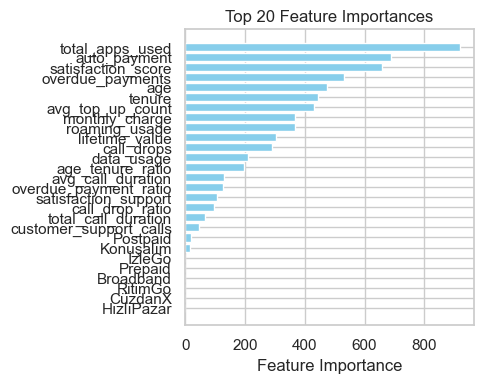

In [37]:
feature_importances = lgb_classifier.feature_importances_
# Match them to the column names
feature_names = df_x_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Select the top 20 features
top_features = importance_df

# Create a horizontal bar chart
plt.figure(figsize=(5, 4))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis so the highest importance is on top
plt.tight_layout()
plt.show()
